## Diamond Analysis Pt5 (actually 4)
### Analyze and Retrain w/ BlueNile Data Only

A few things happened
1.  I found out that all these diamond datasets are either dated or fictious on the web
2.  Cross testing across datasets yielded poor predictions mainly because the data was quite different in pricing
3.  I was able to hack thru the problems downloading bluenile data by running in a time-delayed fetch so now I have 50k of market priced diamonds w/ good attribution (great quantity 140k rows of round cut)

So now the approach is stick w/ bluenile data.  I pulled the entire lot of Round cut diamonds which is 50k+ rows.   We can start w/ that as the baseline dataset.  I do want to combine w/ Tiffany's and other luxury diamond dealers to understand how premium name brands affect pricing.

 
### Step 1 Load and Clean up

In [2]:
# loading important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import myutils 
 
# Loading the data
diamonds5 = pd.read_csv('./blue-nile-download-round-full.csv')
print(diamonds5.shape)
print(diamonds5.describe())
print(diamonds5.columns)

diamonds5.head()

(141458, 27)
       imageUrl         price   sellingIndex
count       0.0  1.414580e+05  141458.000000
mean        NaN  4.599543e+03       0.375252
std         NaN  1.933595e+04       0.150851
min         NaN  2.810000e+02       0.000029
25%         NaN  5.870000e+02       0.288981
50%         NaN  1.248000e+03       0.376647
75%         NaN  3.271000e+03       0.463128
max         NaN  2.055533e+06       0.962772
Index(['carat', 'clarity', 'color', 'culet', 'cut', 'date', 'dateSet', 'depth',
       'detailsPageUrl', 'fluorescence', 'hasVisualization', 'id', 'imageUrl',
       'lxwRatio', 'measurements', 'polish', 'price', 'pricePerCarat',
       'sellingIndex', 'shapeCode', 'shapeName', 'skus', 'symmetry', 'table',
       'v360BaseUrl', 'visualizationImageUrl', 'willArriveForHoliday'],
      dtype='object')


carat clarity  color     culet  \
0  ['0.23']  ['FL']  ['D']  ['None']   
1  ['0.23']  ['FL']  ['D']  ['None']   
2  ['0.23']  ['FL']  ['D']  ['None']   
3  ['0.23']  ['FL']  ['D']  ['None']   
4  ['0.23']  ['FL']  ['D']  ['None']   

                                           cut        date    dateSet  \
0  [{'label': 'Ideal', 'labelSmall': 'Ideal'}]  ['Sep 30']  ['Oct 1']   
1  [{'label': 'Ideal', 'labelSmall': 'Ideal'}]  ['Sep 30']  ['Oct 1']   
2  [{'label': 'Ideal', 'labelSmall': 'Ideal'}]  ['Sep 30']  ['Oct 1']   
3  [{'label': 'Ideal', 'labelSmall': 'Ideal'}]  ['Sep 30']  ['Oct 1']   
4  [{'label': 'Ideal', 'labelSmall': 'Ideal'}]  ['Sep 30']  ['Oct 1']   

      depth                detailsPageUrl fluorescence  ... pricePerCarat  \
0  ['58.8']  ./diamond-details/LD12750672     ['None']  ...    ['$3,787']   
1  ['59.6']  ./diamond-details/LD12389454     ['None']  ...    ['$3,743']   
2  ['59.7']  ./diamond-details/LD12750664     ['None']  ...    ['$3,765']   
3  ['59.8']  ./diamond-details/LD12505728     ['None']  ...    ['$3,630']   
4  ['60.1']  ./diamond-details/LD12505726     ['None']  ...    ['$3,630']   

  sellingIndex  shapeCode  shapeName            skus       symmetry     table  \
0     0.734835     ['RD']  ['Round']  ['LD12750672']  ['Excellent']  ['60.0']   
1     0.521523     ['RD']  ['Round']  ['LD12389454']  ['Excellent']  ['59.0']   
2     0.518767     ['RD']  ['Round']  ['LD12750664']  ['Excellent']  ['60.0']   
3     0.649935     ['RD']  ['Round']  ['LD12505728']  ['Excellent']  ['59.0']   
4     0.411232     ['RD']  ['Round']  ['LD12505726']  ['Excellent']  ['59.0']   

                                         v360BaseUrl  \
0  https://bluenile.v360.in/50/imaged/gia-7313767...   
1  https://bluenile.v360.in/50/imaged/gia-7316836...   
2  https://bluenile.v360.in/50/imaged/gia-2316863...   
3  https://bluenile.v360.in/19/imaged/gia-6322878...   
4  https://bluenile.v360.in/19/imaged/gia-6321890...   

                               visualizationImageUrl willArriveForHoliday  
0  https://bnsec.bluenile.com/bnsecure/diamondvis...                False  
1  https://bnsec.bluenile.com/bnsecure/diamondvis...                False  
2  https://bnsec.bluenile.com/bnsecure/diamondvis...                False  
3  https://bnsec.bluenile.com/bnsecure/diamondvis...                False  
4  https://bnsec.bluenile.com/bnsecure/diamondvis...                False  

[5 rows x 27 columns]

In [3]:
# clean up fields
diamonds5a = diamonds5.copy()
diamonds5a.loc[:,'carat'] = diamonds5a.loc[:,'carat'].to_frame().applymap(myutils.cleanBracketsToF)
diamonds5a.loc[:,'clarity'] = diamonds5a.loc[:,'clarity'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'color'] = diamonds5a.loc[:,'color'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'cut'] = diamonds5a.loc[:,'cut'].to_frame().applymap(myutils.cleanCut)

# clear nulls
pd.set_option('use_inf_as_na', True)

diamonds5a = diamonds5a.loc[~diamonds5a['carat'].isnull()]  
diamonds5a = diamonds5a.loc[~diamonds5a['price'].isnull()]  
diamonds5a = diamonds5a[['carat','color','cut','clarity','price']]
diamonds5a.sample(n=5,random_state=11 )


carat color    cut clarity  price
14465    0.30     I  Ideal     SI2    362
21579    0.30     J  Ideal    VVS1    462
57231    0.41     D  Ideal     SI1    867
119118   1.01     G  Ideal     VS2   6800
11613    0.30     D  Ideal     SI2    491

In [4]:
# drop any nulls
print(diamonds5a.shape)
diamonds5a = diamonds5a.dropna()
print(diamonds5a.shape)


(141458, 5)
(141458, 5)


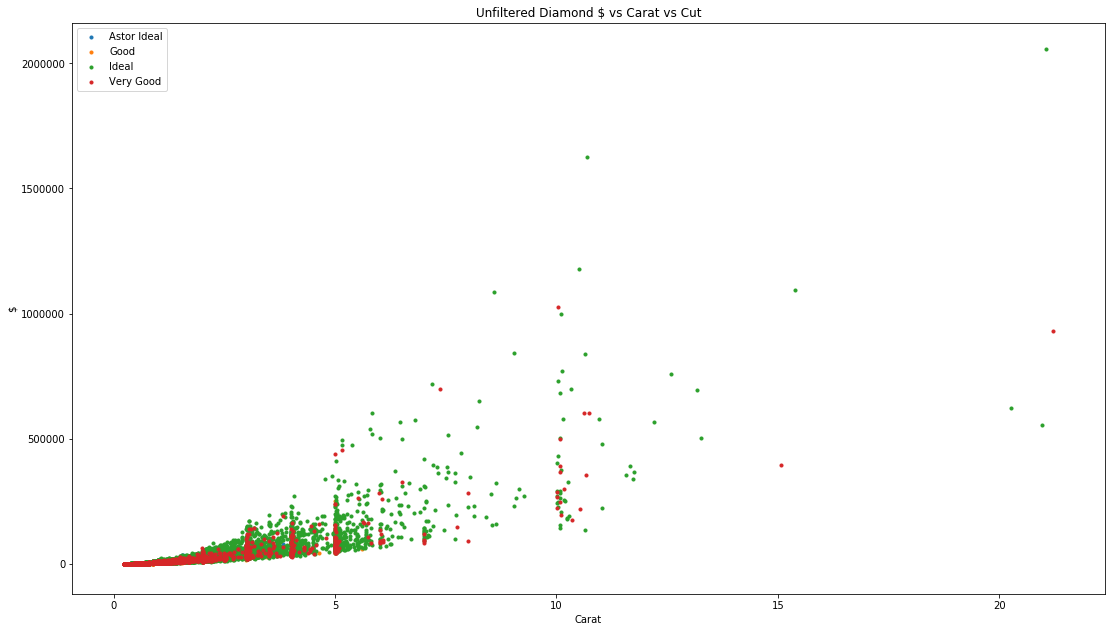

In [5]:
# full dataset
fig, ax = plt.subplots()
for c, df in diamonds5a.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Unfiltered Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [6]:
# narrow down to <= 5 carats since beyond this has alot less data

diamonds5b = diamonds5a.loc[(diamonds5a['carat'] <= 4.5)]
diamonds5b.describe()


carat          price
count  140838.000000  140838.000000
mean        0.658144    3823.331927
std         0.517062    9050.689493
min         0.230000     281.000000
25%         0.330000     586.000000
50%         0.500000    1240.000000
75%         0.780000    3181.000000
max         4.500000  272018.000000

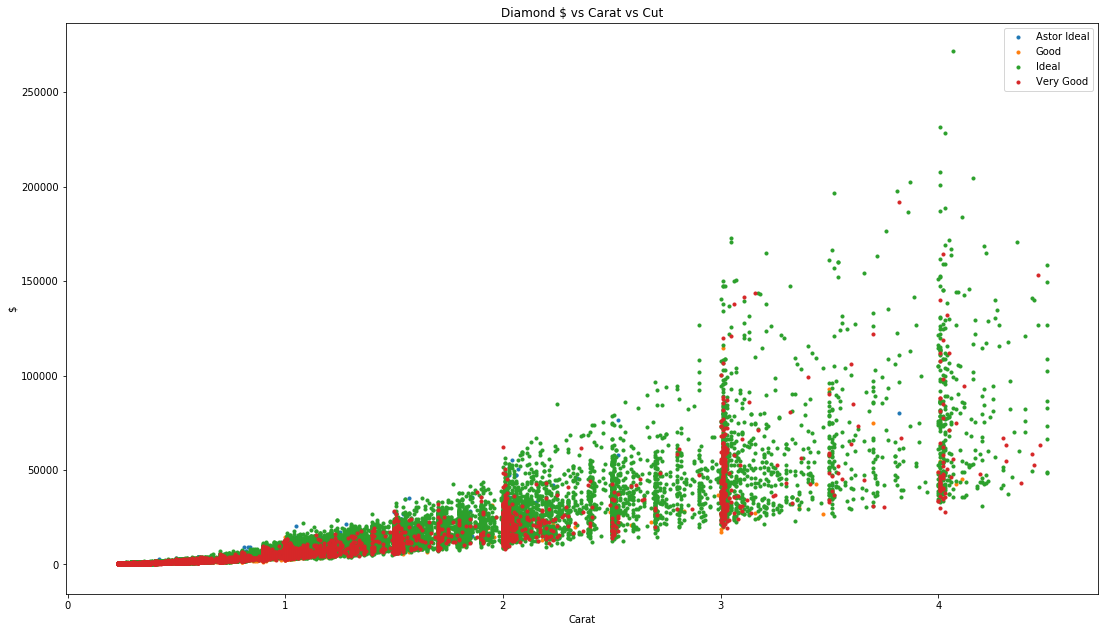

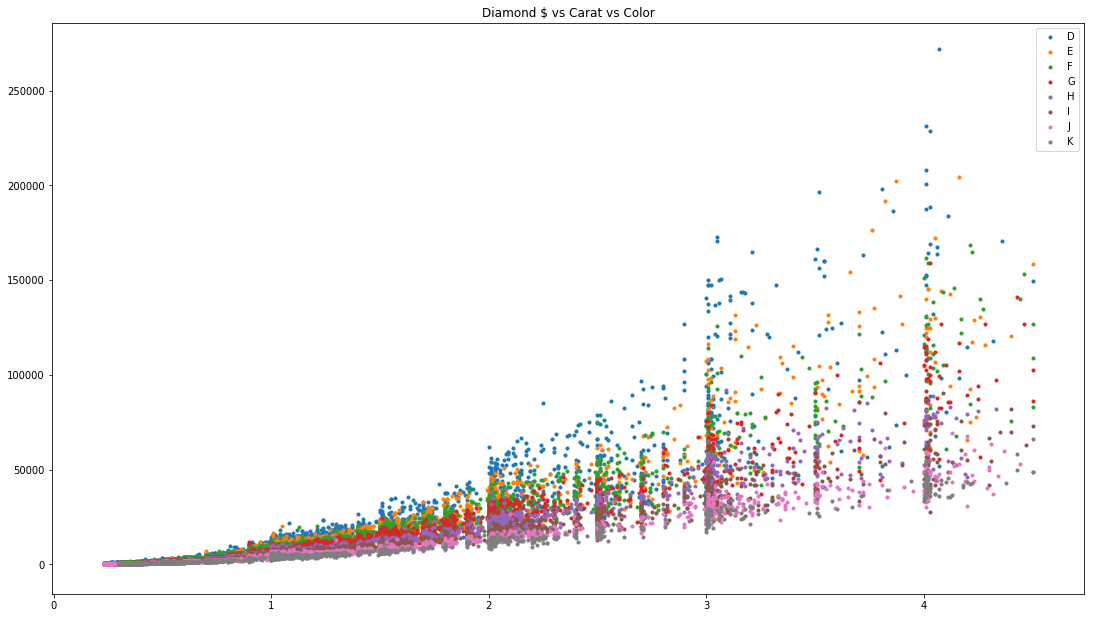

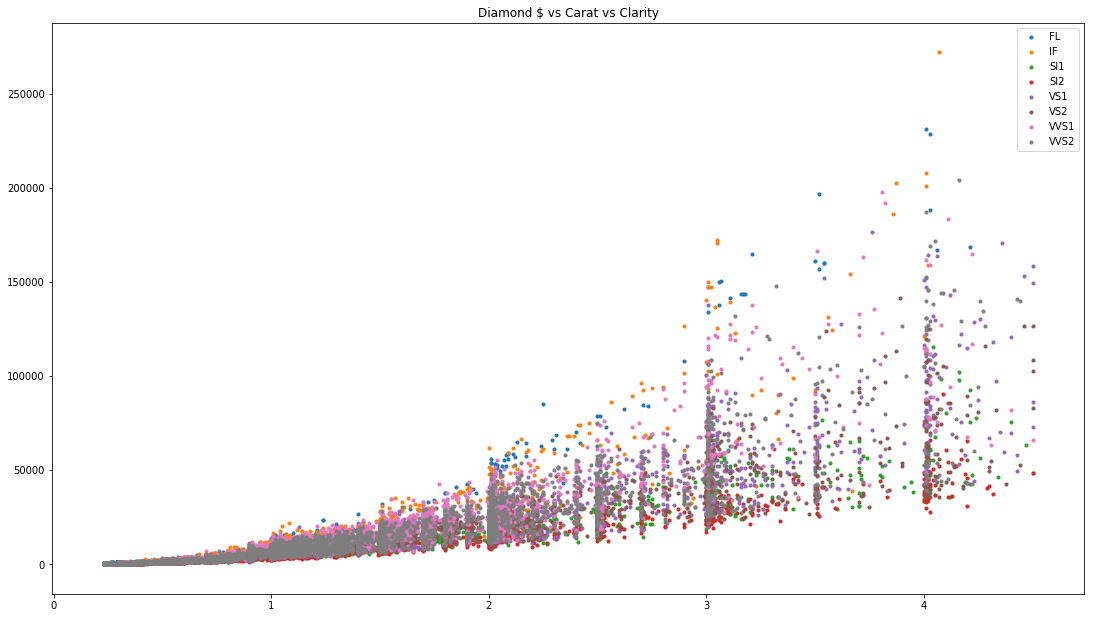

In [7]:
# scatter carat to price
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('color'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Color')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('clarity'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Clarity')
fig.set_size_inches(18.5, 10.5)
plt.show()



### OneHot the categoricals and build final diamonds5c set

In [8]:
cut = pd.get_dummies( diamonds5b['cut'], prefix='cut_')
color = pd.get_dummies( diamonds5b['color'], prefix='color_')
clarity = pd.get_dummies( diamonds5b['clarity'], prefix='clarity_')
diamonds5c = diamonds5b[['carat','price']]
diamonds5c = diamonds5c.join(cut).join(color).join(clarity)

assert(len(diamonds5c.loc[diamonds5c['price'].isnull()]) == 0)
diamonds5c.head()


carat  price  cut__Astor Ideal  cut__Good  cut__Ideal  cut__Very Good  \
0   0.23    871                 0          0           1               0   
1   0.23    861                 0          0           1               0   
2   0.23    866                 0          0           1               0   
3   0.23    835                 0          0           1               0   
4   0.23    835                 0          0           1               0   

   color__D  color__E  color__F  color__G  ...  color__J  color__K  \
0         1         0         0         0  ...         0         0   
1         1         0         0         0  ...         0         0   
2         1         0         0         0  ...         0         0   
3         1         0         0         0  ...         0         0   
4         1         0         0         0  ...         0         0   

   clarity__FL  clarity__IF  clarity__SI1  clarity__SI2  clarity__VS1  \
0            1            0             0             0             0   
1            1            0             0             0             0   
2            1            0             0             0             0   
3            1            0             0             0             0   
4            1            0             0             0             0   

   clarity__VS2  clarity__VVS1  clarity__VVS2  
0             0              0              0  
1             0              0              0  
2             0              0              0  
3             0              0              0  
4             0              0              0  

[5 rows x 22 columns]

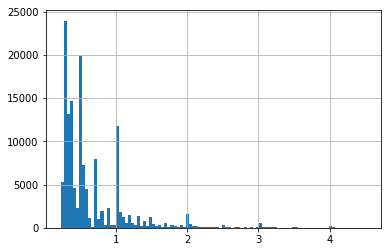

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

diamonds5c['carat'].hist(bins=100)

Text(0, 0.5, 'Number')

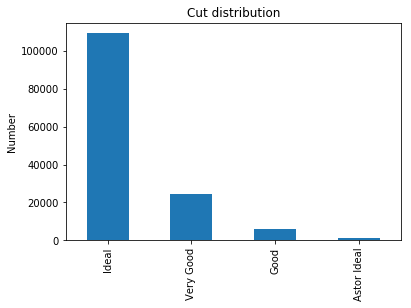

In [10]:
cuts = diamonds5b['cut'].value_counts()
cuts.plot(kind='bar')
plt.title('Cut distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

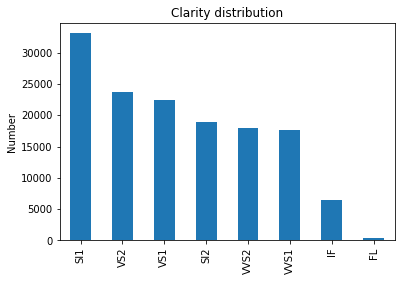

In [11]:
c = diamonds5b['clarity'].value_counts()
c.plot(kind='bar')
plt.title('Clarity distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

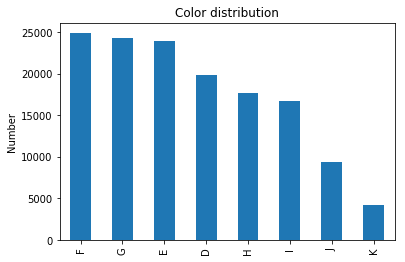

In [12]:
c = diamonds5b['color'].value_counts()
c.plot(kind='bar')
plt.title('Color distribution')
plt.ylabel('Number')

## Normalize/Scale the other input columns

In [87]:
from sklearn import preprocessing

assert(len(diamonds5c.loc[diamonds5c['carat'].isnull()]) == 0)

### did not normalize one-hots, i dont think we need to but tried it out
# caratDF = diamonds5c['carat'].to_frame()
# scaler = preprocessing.StandardScaler().fit(caratDF)
# caratDF = pd.DataFrame(scaler.transform(caratDF),columns=['caratScaled'], index=diamonds5c.index)
# diamonds5d = diamonds5c

### normalizing one-hots probably not necessary
scaler = preprocessing.StandardScaler().fit(diamonds5c.drop(columns=['price']))
# caratDF = pd.DataFrame(scaler.transform(caratDF),columns=['caratScaled'], index=diamonds5c.index)
diamonds5d = pd.DataFrame(scaler.transform(diamonds5c.drop(columns=['price'])), 
                          columns=diamonds5c.drop(columns=['price']).columns, index=diamonds5c.index)
diamonds5d['price'] = diamonds5c['price']
print(caratDF.shape)
print(diamonds5c.shape)
print(diamonds5d.shape)

diamonds5d = pd.concat([ diamonds5d, caratDF], axis=1)
diamonds5d.tail()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


(140838, 1)
(140838, 22)
(140838, 22)


carat  cut__Astor Ideal  cut__Good  cut__Ideal  cut__Very Good  \
140896  7.430184         -0.089855  -0.209527    0.535156       -0.456681   
140897  7.430184         -0.089855  -0.209527    0.535156       -0.456681   
140898  7.430184         -0.089855  -0.209527    0.535156       -0.456681   
140899  7.430184         -0.089855  -0.209527    0.535156       -0.456681   
140900  7.430184         -0.089855  -0.209527    0.535156       -0.456681   

        color__D  color__E  color__F  color__G  color__H  ...  clarity__FL  \
140896 -0.405478 -0.452052  2.158758 -0.455999 -0.378188  ...    -0.055662   
140897 -0.405478 -0.452052  2.158758 -0.455999 -0.378188  ...    -0.055662   
140898 -0.405478 -0.452052  2.158758 -0.455999 -0.378188  ...    -0.055662   
140899 -0.405478 -0.452052 -0.463229  2.192987 -0.378188  ...    -0.055662   
140900 -0.405478 -0.452052 -0.463229 -0.455999 -0.378188  ...    -0.055662   

        clarity__IF  clarity__SI1  clarity__SI2  clarity__VS1  clarity__VS2  \
140896    -0.218597     -0.554127      -0.39473     -0.435893      2.223011   
140897    -0.218597     -0.554127      -0.39473     -0.435893      2.223011   
140898    -0.218597     -0.554127      -0.39473     -0.435893      2.223011   
140899    -0.218597     -0.554127      -0.39473     -0.435893      2.223011   
140900    -0.218597     -0.554127      -0.39473     -0.435893     -0.449840   

        clarity__VVS1  clarity__VVS2   price  caratScaled  
140896      -0.379291      -0.382859   82962     7.430184  
140897      -0.379291      -0.382859  126878     7.430184  
140898      -0.379291      -0.382859  108662     7.430184  
140899      -0.379291      -0.382859  102501     7.430184  
140900       2.636496      -0.382859   66129     7.430184  

[5 rows x 23 columns]

## Now ready to train a models

We will step thru a few cases
1. Linear using carat only, then color, clarity, cut only
2. Linear using carat + one of the others
3. Linear using carat + two of the others
4. Linear using all 4c's
5. RandomForest using all 4c's
6. XGBoost using all 4c's

In [88]:
from sklearn.model_selection import train_test_split
from myutils import *

train, test = train_test_split(diamonds5d, random_state=12)
train_Y, test_Y = train['price'], test['price']

## Experiments 1a-1d -- single sets of features

Score:  0.7429062134434536


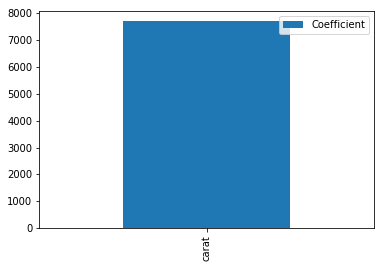

Score:  0.00036189539872211185


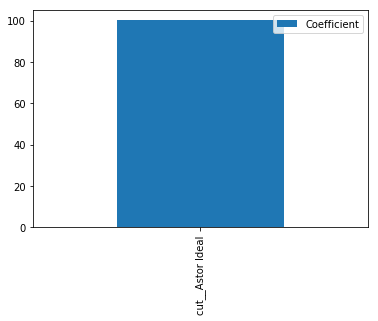

Score:  0.0005981868746838259


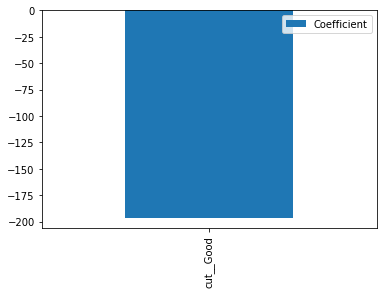

Score:  0.0011341056509739378


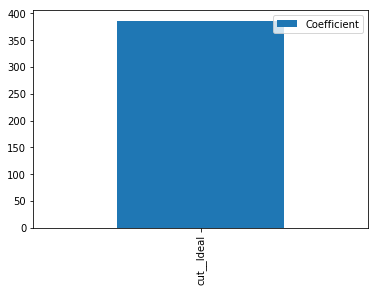

Score:  0.0008231695165885621


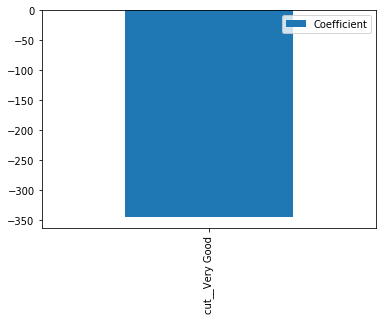

Score:  0.004363006915470091


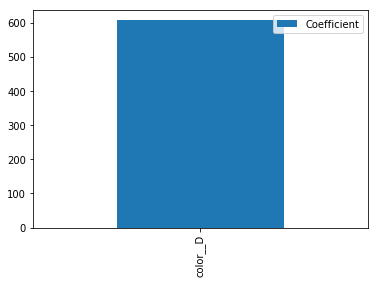

Score:  8.549480883968119e-05


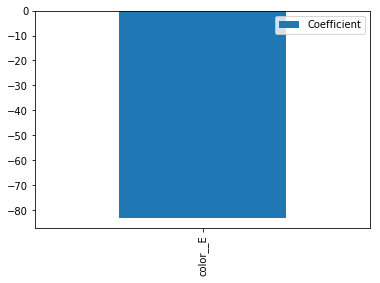

Score:  -0.00019886752646036676


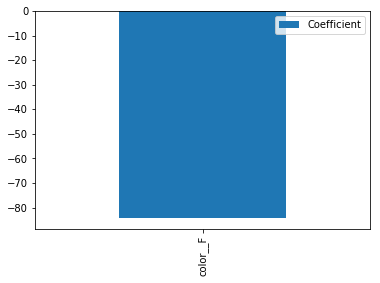

Score:  1.0033613446203127e-05


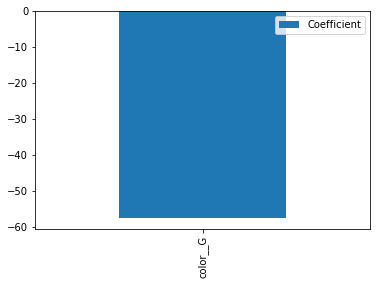

Score:  -0.00010447400370927618


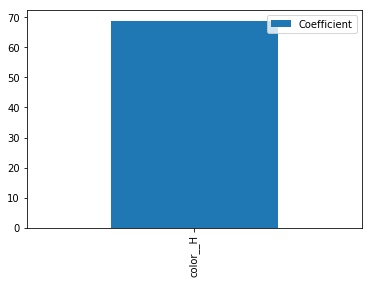

Score:  0.0006992632261206833


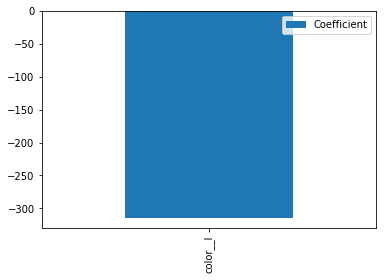

Score:  0.00025000132682473364


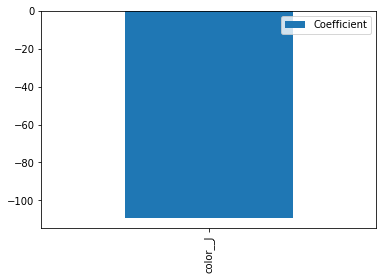

Score:  0.00013347221331738712


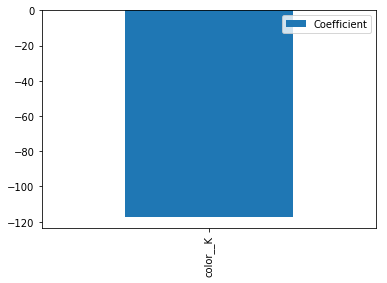

Score:  0.0043934342003263405


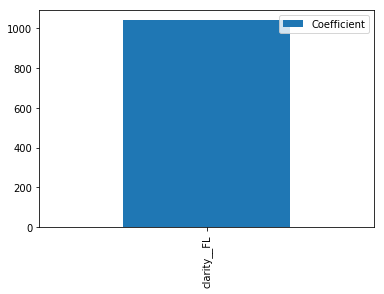

Score:  0.0007998133278723785


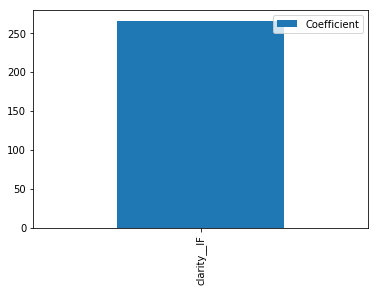

Score:  0.005147048833626489


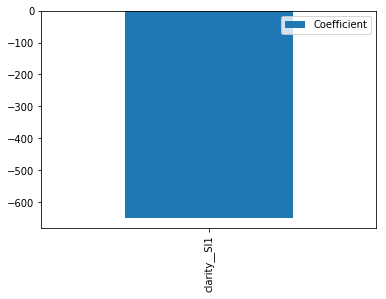

Score:  0.004309058141664157


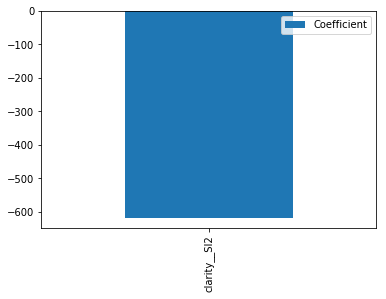

Score:  0.0028764946355206433


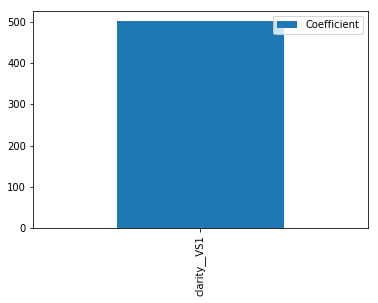

Score:  1.5730247203693537e-06


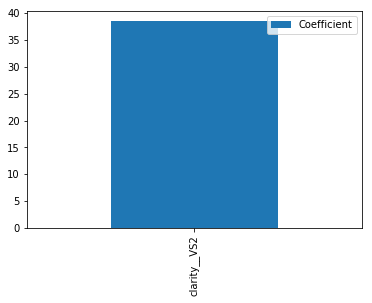

Score:  0.0008382090888334748


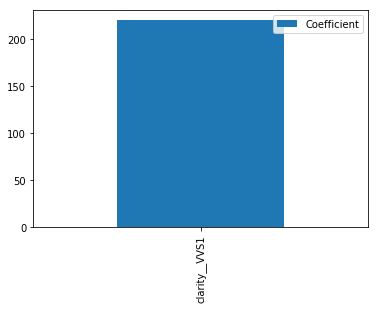

Score:  0.0007173589422281301


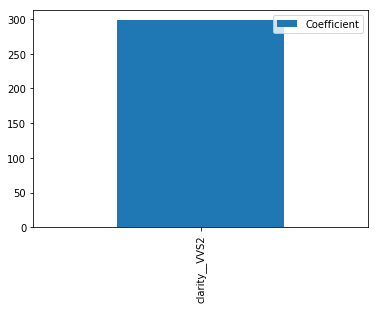

Score:  0.7429062134434536


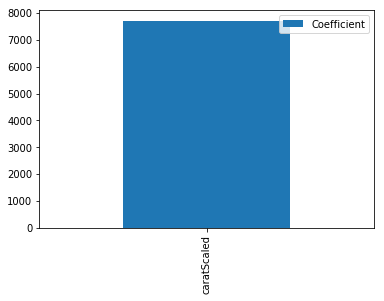

In [89]:
columnSets = ['carat', 'cut__Astor Ideal', 'cut__Good', 'cut__Ideal',
       'cut__Very Good', 'color__D', 'color__E', 'color__F', 'color__G',
       'color__H', 'color__I', 'color__J', 'color__K', 'clarity__FL',
       'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1',
       'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2', 'caratScaled']

scores = {}
for c in columnSets:
    train1 = train[[c]]
    test1 = test[[c]]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=False)
    scores[c] = score


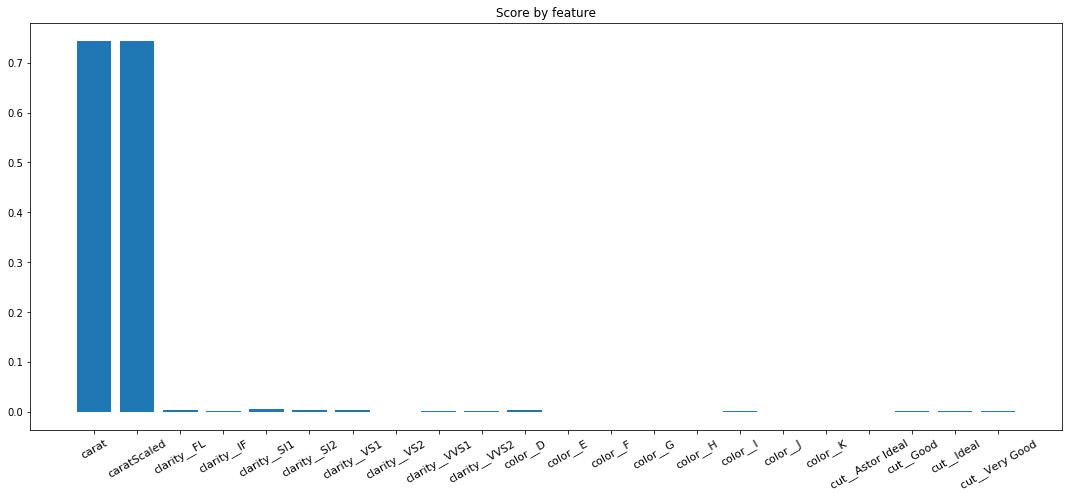

In [90]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()

## Experiement 2* -- carat ++ features (2-sets)

Score:  0.7429955361707932


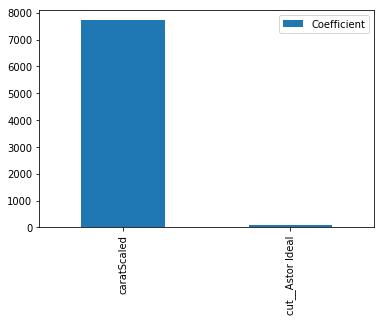

Score:  0.7443742492064782


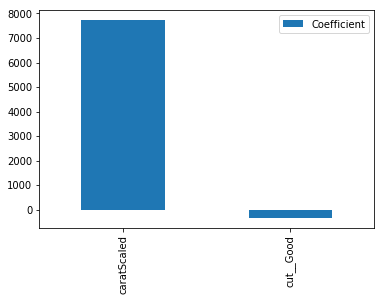

Score:  0.7449141424802426


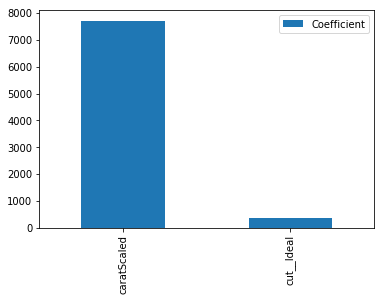

Score:  0.7438687136577593


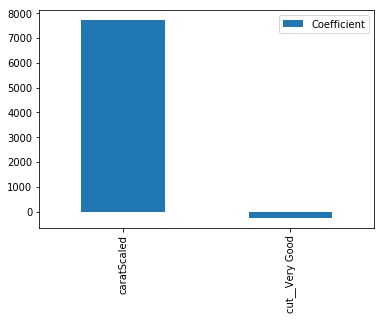

Score:  0.7462410338373623


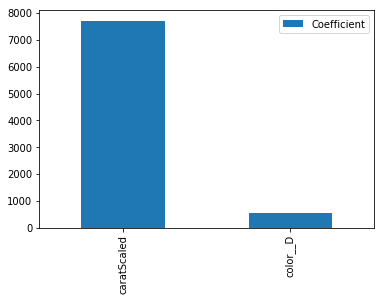

Score:  0.7444929517623036


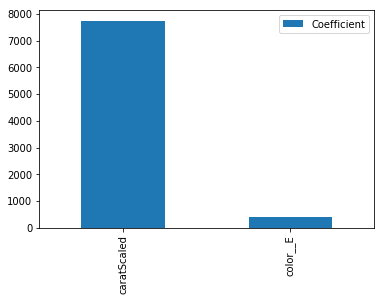

Score:  0.7438902991216383


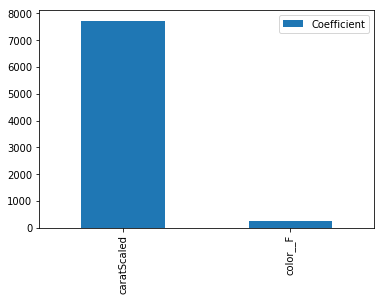

Score:  0.7431911608284978


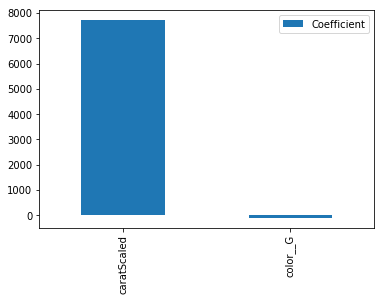

Score:  0.7438961300274131


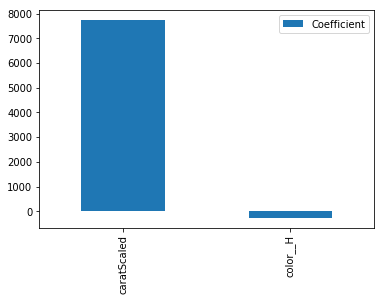

Score:  0.7438368956968104


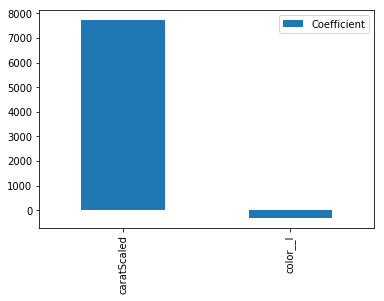

Score:  0.7456433632242072


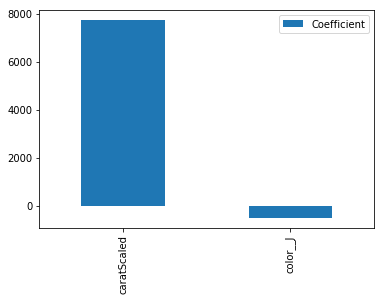

Score:  0.7446915059481956


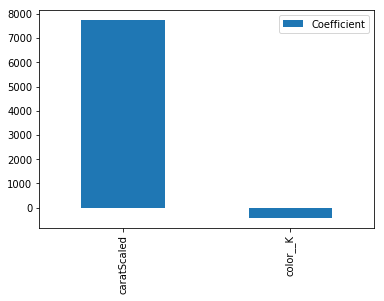

Score:  0.7453332034525652


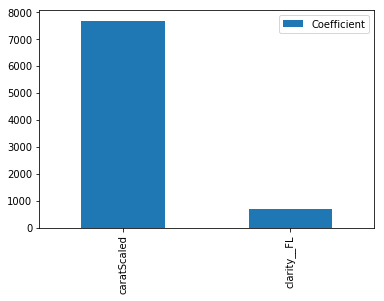

Score:  0.7446318785584658


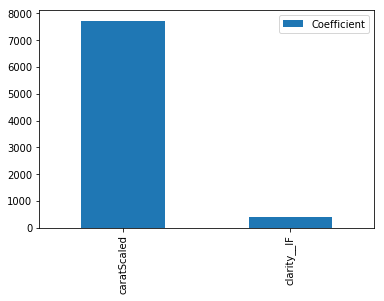

Score:  0.7440131737315754


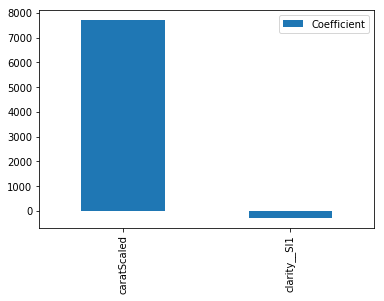

Score:  0.7451873690665156


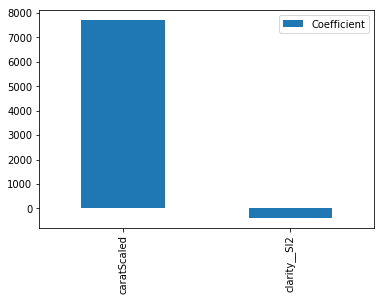

Score:  0.7429395392771033


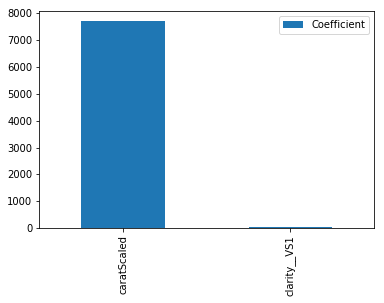

Score:  0.7430571753657274


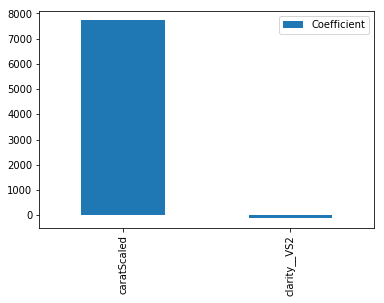

Score:  0.7446809495688347


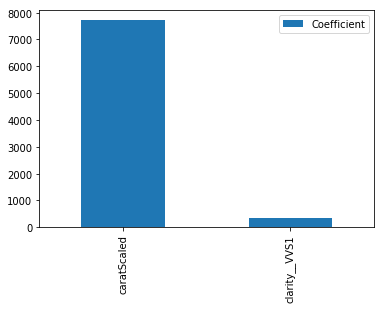

Score:  0.7433263136869419


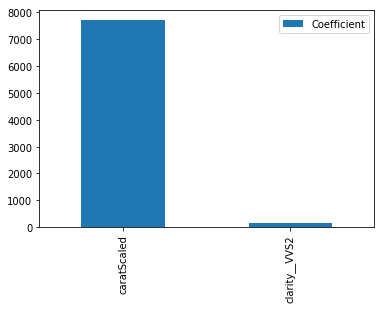

In [91]:
columnSets = [ 'cut__Astor Ideal', 'cut__Good', 'cut__Ideal',
       'cut__Very Good', 'color__D', 'color__E', 'color__F', 'color__G',
       'color__H', 'color__I', 'color__J', 'color__K', 'clarity__FL',
       'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1',
       'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']

scores = {}
for c in columnSets:
    train1 = train[['caratScaled',c]]
    test1 = test[['caratScaled',c]]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=False)
    scores[c] = score


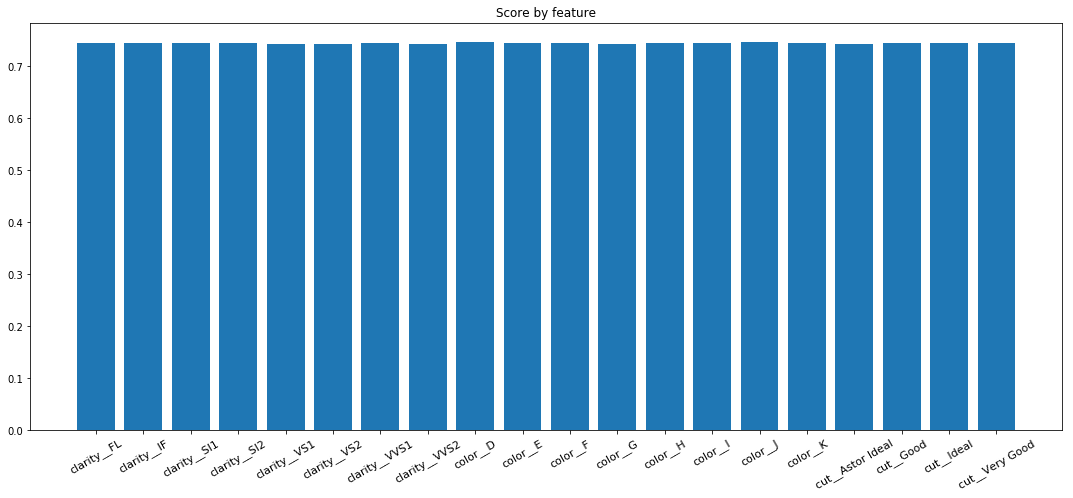

In [92]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()

### 2-sets all produce about the same, 74% -- modest increase.

Next try sets of the same onehot groups and see if any difference

Score:  0.7456445195691127


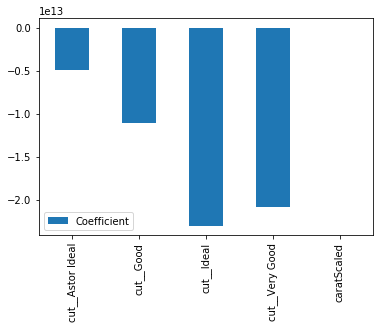

Score:  0.75414827556375


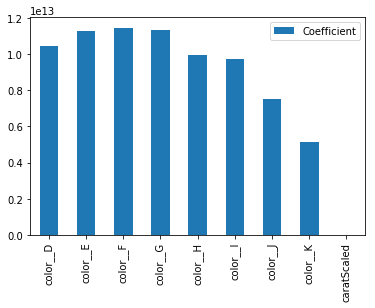

Score:  0.7518635962003368


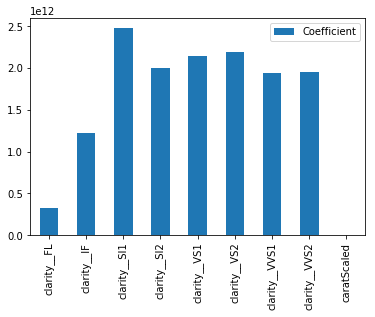

In [93]:
columnSets = [['cut__Astor Ideal', 'cut__Good', 'cut__Ideal','cut__Very Good'],
              ['color__D', 'color__E', 'color__F', 'color__G','color__H', 'color__I', 'color__J', 'color__K'],
              ['clarity__FL','clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1','clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']]

scores = {}
for c in columnSets:
    train1 = train[c+['caratScaled']]
    test1 = test[c+['caratScaled']]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=False)
    scores[c[0][:5]] = score

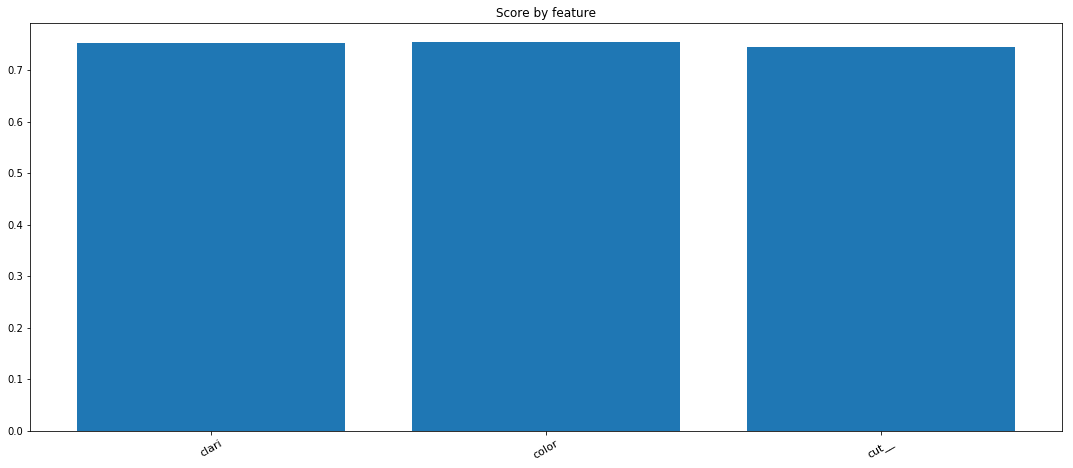

In [94]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()

## Adding Color or Clarity raises it to 75% -- not much improvement.   

Try all remaining combinations of columnSets: (c1+c2, c1+c3, c2+c3, c1+c2+c3)

Score:  0.7561714401163773


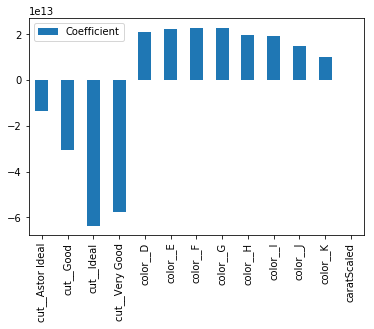

Score:  0.7633852939288275


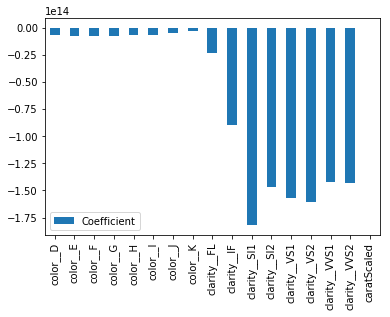

Score:  0.7539273224210211


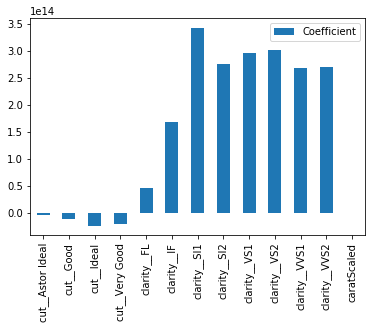

Score:  0.7647541821138132


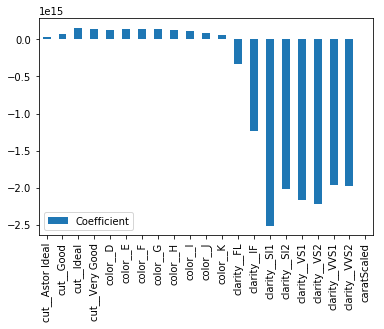

In [95]:
cs = [['cut__Astor Ideal', 'cut__Good', 'cut__Ideal','cut__Very Good'],
              ['color__D', 'color__E', 'color__F', 'color__G','color__H', 'color__I', 'color__J', 'color__K'],
              ['clarity__FL','clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1','clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']]

scores = {}
for c in [ cs[0]+cs[1], cs[1]+cs[2], cs[0]+cs[2], cs[0]+cs[1]+cs[2]]:
    train1 = train[c + ['caratScaled']]
    test1 = test[c + ['caratScaled']]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=False)
    scores[str(c)] = score


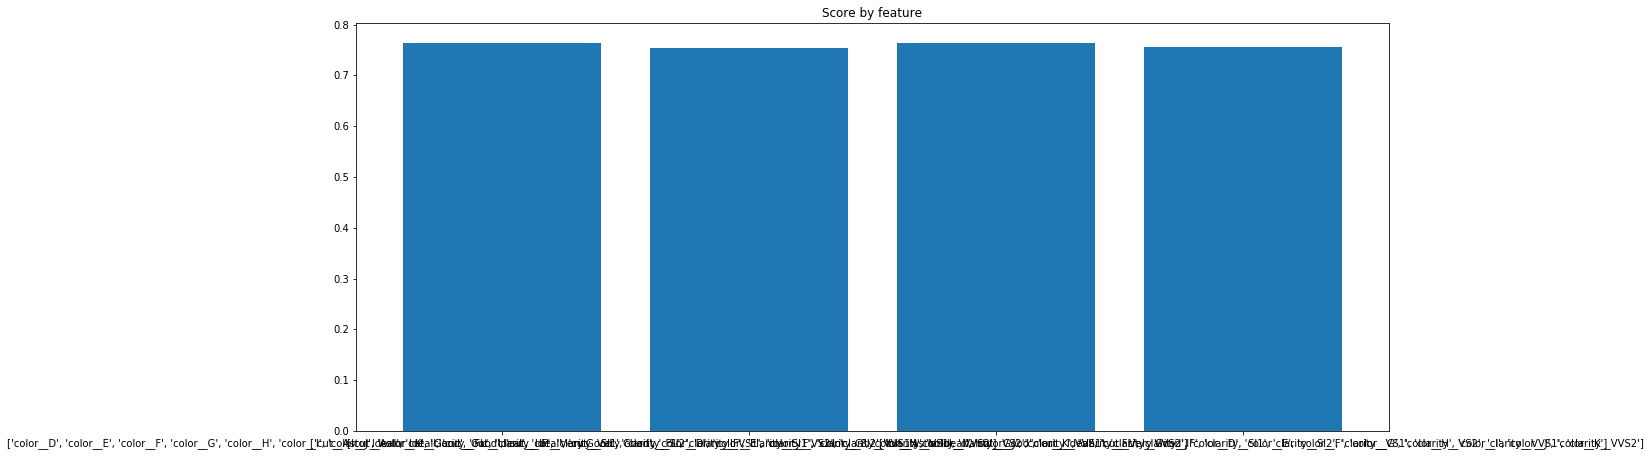

In [96]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
#plt.xticks(fontsize=11, rotation=30)
plt.show()

### Not much difference, 76.4% if we leave out color but add the rest (3rd bar is Carat+Cut+Clarity)
